# Simple Random Sampling: Not So Simple

Random sampling is one of the most fundamental tools in Statistics.

Used for:

+ Surveys and extrapolation
    - Opinion surveys
    - Census (for some purposes) and Current Population Survey
    - Environmental statistics
    - Litigation, including class actions, discrimination, ...
+ Experiments
    - Medicine
    - Agriculture
    - Marketing
    - Product development
+ Quality control and auditing
    - Process control
    - Financial auditing
    - Election auditing

and on and on.

_Simple random sampling_ refers to drawing $k \le n$ items from a population of $n$ items, in such a way that
each of the $n \choose k$ subsets of size $k$ is equally likely.

Many standard statistical methods assume the sample is drawn in this way, or allocated between treatment and control in this way (e.g., $k$ of $n$ subjects are assigned to treatment, and the remaining $n-k$ to control).


This notebook examines common strategies for drawing pseudo-random samples of size $k$ from a population of size $n$. 

It has a brief disussion of pseudo-random number generators (PRNGs) and of algorithms used to select pseudo-random samples using PRNGs.

Among other things, it finds bounds on the number of samples that can be generated using a variety of PRNGs, for a number of algorithms that use PRNs to generate samples:

+ a common algorithm that involves assigning a PRN to each of the $n$ elements, then taking those elements assigned the smallest $k$ numbers to be the sample (`PIKK` for "permute and keep $k$")
+ algorithm `R`, a streamable algorithm that also uses at least one PRN per element of the population, but avoids the sort
+ algorithm `Random-Sample` on p. 130 of [Cormen et al. (2009)](https://mitpress.mit.edu/books/introduction-algorithms), which uses only $k$ random integers
+ a hypothetical sampling algorithm that uses an optimal coding of samples to turn strings of $\log_2{n \choose k}$ bits into samples of size $k$

It also considers how that affects the bias and uncertainty of estimates based on such pseudo-random samples rather than on actual simple random samples.

PRNGs considered include [linear congruential generators](https://en.wikipedia.org/wiki/Linear_congruential_generator) (LCGs, including [RANDU](https://en.wikipedia.org/wiki/RANDU)), and the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister). The behavior of the [middle square method](https://en.wikipedia.org/wiki/Middle-square_method) is worse. 
There is some discussion of using cryptographic hash functions to generate PRNs.

[Kellie Ottoboni](http://www.stat.berkeley.edu/~kellieotto/), [Ronald L. Rivest](http://people.csail.mit.edu/rivest/) and [Philip B. Stark](www.stat.berkeley.edu/~stark)



## References

1. Cormen, T.H., C.E. Leiserson, R.L. Rivest and C. Stein, 2009. _Introduction to Algorithms, 3rd edition_, MIT Press.
1. Fishman, G.S., and L.R. Moore, 1981. In Search of Correlation in Multiplicative Congruential Generators with Modulus 2\*\*31-1, _Computer Science and Statistics: Proceedings of the 13 Symposium on the Interface_, William F. Eddy, ed., Springer Verlag, New York.
1. Knuth, D., 1997 _The Art of Computer Programming, V.II: Seminumerical methods_, 3rd edition, Addison-Wesley, Boston.
1. L'Ecuyer, P. and R. Simard, 2007. TestU01: A C Library for Empirical Testing of Random Number Generators, _ACM Trans. Math. Softw._, _33_, http://doi.acm.org/10.1145/1268776.1268777
1. Marsaglia, G., 1968. Random Numbers Fall Mainly in the Planes, _PNAS_, _61_, 25&ndash;28.
1. Marsaglia, G., 2003. Xorshift RNGs. _Journal of Statistical Software_, _8_, 1&ndash;6.
1. Matsumoto, M., and T. Nishimura, 1998. 8). Mersenne twister: a 623-dimensionally equidistributed uniform pseudo-random number generator, _ACM Transactions on Modeling and Computer Simulation_, _8_, 3&ndash;30. doi:10.1145/272991.272995
1. NIST Computer Security Division, _Random Number Generation_ http://csrc.nist.gov/groups/ST/toolkit/rng/
1. O'Neill, M.E., 2015. PCG: A Family of Simple Fast Space-Efficient Statistically Good Algorithms for Random Number Generation, submitted to _ACM Transactions on Mathematical Software_. http://www.pcg-random.org/pdf/toms-oneill-pcg-family-v1.02.pdf
1. http://www.pcg-random.org/
1. Shannon, C.E., 1948. A Mathematical Theory of Communication, _Bell System Technical Journal, 27_, 379&ndash;423, 623&ndash;656. 
1. Vitter, J.S., 1985. Random Sampling with a Reservoir, _ACM Transactions on Mathematical Software, 11_, 37&ndash;57.
1. Wikipedia articles, including https://en.wikipedia.org/wiki/Mersenne_Twister, https://en.wikipedia.org/wiki/Linear_congruential_generator, https://en.wikipedia.org/wiki/Comparison_of_hardware_random_number_generators, https://en.wikipedia.org/wiki/Pseudorandom_number_generator, https://en.wikipedia.org/wiki/List_of_random_number_generators 

Highly encourage you to look at the customer reviews of _A Million Random Digits with 100,000 Normal Deviates_ on Amazon.com 

https://www.amazon.com/Million-Random-Digits-Normal-Deviates/dp/0833030477

> Such a terrific reference work! But with so many terrific random digits, it's a shame they didn't sort them, to make it easier to find the one you're looking for.

> While the printed version is good, I would have expected the publisher to have an audiobook version as well. 

> The book is a promising reference concept, but the execution is somewhat sloppy. Whatever generator they used was not fully tested. The bulk of each page seems random enough. However at the lower left and lower right of alternate pages, the number is found to increment directly.

> If you like this book, I highly recommend that you read it in the original binary. As with most translations, conversion from binary to decimal frequently causes a loss of information and, unfortunately, it's the most significant digits that are lost in the conversion.

> At first, I was overjoyed when I received my copy of this book. However, when an enemy in my department showed me HER copy, I found that they were the OPPOSITE of random - they were IDENTICAL.

In [1]:
%matplotlib inline
from __future__ import division
import math
import numpy as np
import scipy as sp
from scipy.misc import comb, factorial
from scipy.optimize import brentq
from scipy.stats import chisquare
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Pseudo-random number generators (PRNGs)

Most computers lack the hardware needed to generate truly random numbers. (But see, e.g., https://en.wikipedia.org/wiki/Comparison_of_hardware_random_number_generators.  As of 23 June 2016, www.random.org claims to have produced $1.30 \times 10^9$ random bits. That's aa little less than 10 full periods of a PRNG with 32-bit output and 32-bit state.)

Instead, they use algorithms called pseudo-random number generators (PRNGs) to generate deterministic sequences from an initial "seed," which generally can be set by the user, for instance to an externally generated random value.

Depending on the quality of the PRNG, the sequences behave more or less like sequences of random numbers.

Each time a number is generated, the PRNG's "state" changes.

Must consider fitness for use of PRNGs. What's "good enough?"

Different requirements for statistics with small data, simulations, statistics with big data, and cryptography.

## Properties of PRNGs

+ dimension of output
    - commonly 32 bits, but some have more
    
+ number of states
    - dimension of state space in bits
    - sometimes state = output, but better generators generally have output = f(state)

+ period
    - maximum over initial states of the number of states visited before repeating
    - period &le; number of states
    - if state has $s$ bits, period $\le 2^s$
    - for some PRNGs, period is much less than number of states
    - for some seeds for some PRNGs, number of states visited is much less than period
    
+ $k$-distribution
    - suppose $\{X_i\}$ is sequence of $P$ $w$-bit integers
    - define $t_v(X_i)$ to be the first $v$ bits of $X_i$
    - $\{X_i\}$ is $k$-distributed to $v$-bit accuracy if each of the $2^{kv}-1$ possible nonzero $kv$-bit vectors occurs equally often among the $P$ $kv$-bit vectors
$$ (t_v(X_i),\,t_v(X_{i+1}), \ldots ,t_v(X_{i+k-1}))\quad (0\le i<P),$$
and the zero vector occurs once less often.
    - amounts to a form of uniformity in $k$-dimensional space, over an entire cycle
    - does not measure dependence or other "serial" properties

+ sensitivity to initial state; burn-in
    - many PRNGs don't do well if the seed has too many zeros
    - some require many iterations before output behaves well
    - for some seeds, some PRNGs repeat very quickly

## Some PRNGs

### Middle Square

Dates to Franciscan friar ca. 1240 (per [Wikipedia](https://en.wikipedia.org/wiki/Middle-square_method)); reinvented by von Neumann ca. 1949.

Take $n$-digit number, square it, use middle $n$ digits as the "random" and the new seed.

E.g., for $n=4$, take $X_0 = 1234$.

$1234^2 = 1522756$, so $X_1 = 2275$.

$2275^2 = 5175625$, so $X_2 = 7562$.

+ $10^n$ possible states, but not all attainable from a given seed
+ period at most $8^n$, but can be very short. E.g., for $n=4$,
    - 0000, 0100, 2500, 3792, & 7600 repeat forever
    - 0540 &rightarrow; 2916 &rightarrow; 5030 &rightarrow; 3009 &rightarrow; 0540


### Linear Congruential Generators (LCGs)

$$ X_{n+1} = (aX_n +c)\mod m.$$

LCG period is at most $m$.

#### Hull-Dobell Theorem: the period of an LCG is $m$ for all seeds $X_0$ iff

+ $m$ and $c$ are relatively prime
+ $a-1$  is divisible by all prime factors of $m$
+ $a-1$  is divisible by 4 if $m$ is divisible by 4


### RANDU

RANDU is a particularly bad [linear congruential generator](https://en.wikipedia.org/wiki/Linear_congruential_generator) promulgated in the 1960s and widely copied.

RANDU is given by the recursion

$$ X_{j+1} = 65539 X_j\mod 2^{31}.$$

It has a short period ($2^{29}$), all its outputs are odd integers. It fails the spectral test.

Triples of values from RANDU fall on 15 planes in 3-dimensional space, as shown below.

In [5]:
# LCG; defaults to RANDU, a particularly bad choice
class lcgRandom: # defaults to RANDU: BEWARE!
    def __init__(self, seed=1234567890, A=0, B=65539, M = 2**31): 
        self.state = seed
        self.A = A
        self.B = B
        self.M = M
        
    def getState(self):
        return self.state, self.A, self.B, self.M
    
    def setState(self,seed=1234567890, A=0, B=65539, M = 2**31):
        self.state = seed
        self.A = A
        self.B = B
        self.M = M

    def nextRandom(self):
        self.state = (self.A + self.B * self.state) % self.M
        return self.state/self.M

    def random(self, size=None):  # vector of rands
        if size==None:
            return self.nextRandom()
        else: 
            return np.reshape(np.array([self.nextRandom() for i in np.arange(np.prod(size))]), size)
    
    def randint(self, low=0, high=None, size=None):  # integer between low (inclusive) and high (exclusive)
        if high==None:  # numpy.random.randint()-like behavior
            high, low = low, 0
        if size==None:
            return low + np.floor(self.nextRandom()*(high-low)) # NOT AN ACCURATE ALGORITHM! See below.
        else:
            return low + np.floor(self.random(size=size)*(high-low))
        
randu = lcgRandom()  # default values are RANDU

# test random()
print randu.random()
print randu.random(size=(4,2))

# test randint()
print randu.randint(1,5)
print randu.randint(-1,10,size=(3,2))

0.746705110185
[[ 0.3062164   0.11695244]
 [ 0.94576698  0.62202994]
 [ 0.22027683  0.72339154]
 [ 0.35785771  0.63662245]]
3.0
[[ 8.  7.]
 [ 9.  7.]
 [ 8. -1.]]


In [11]:
# generate triples using RANDU
reps = int(10**5)

xs = np.transpose(randu.random(size=(reps,3)))

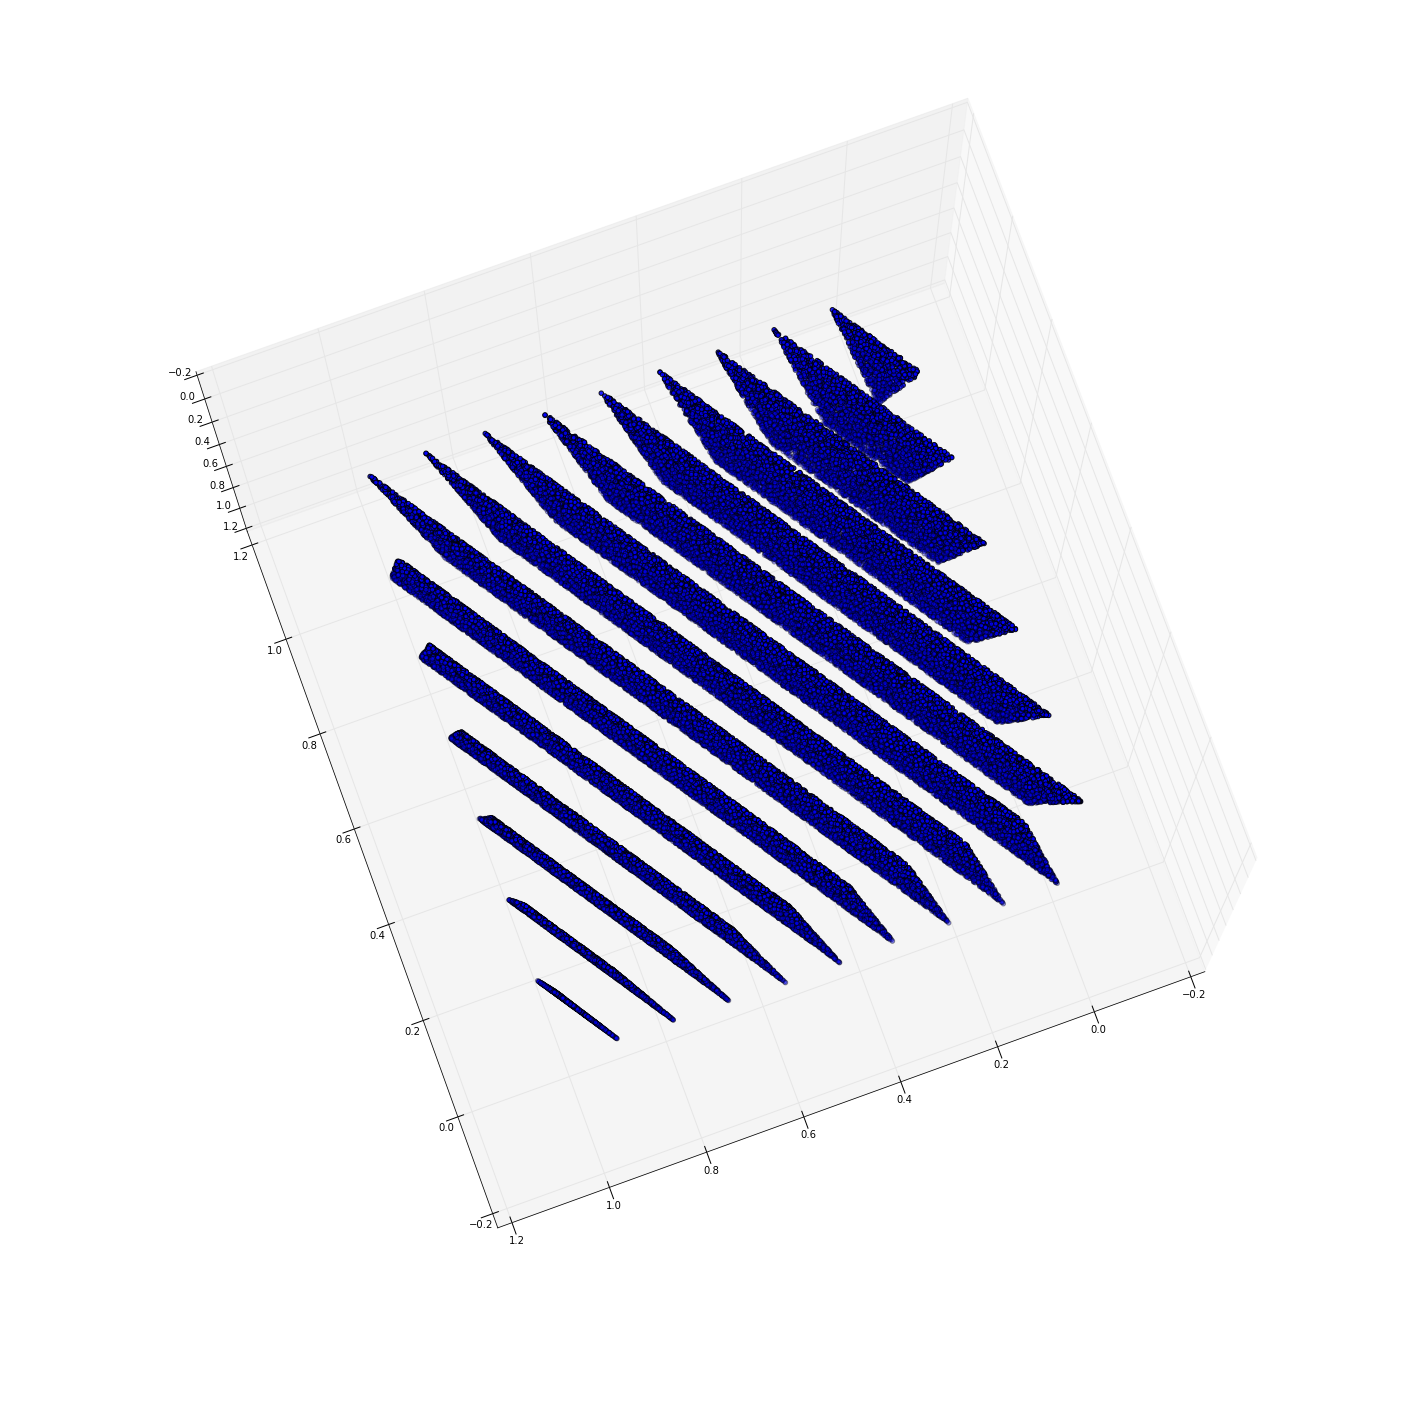

In [12]:
# plot the triples as points in R^3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs[0],xs[1], xs[2])

plt.rcParams['figure.figsize'] = (25.0, 25.0) 

ax.view_init(-100,110)

plt.show()

### Wichmann-Hill (1982)

Sum of 3 LCGs. Period is 6,953,607,871,644. 

    def WH(s1, s2, s3):
        s1 = (171 * s1) % 30269
        s2 = (172 * s2) % 30307
        s3 = (170 * s3) % 30323
        r = (s1/30269 + s2/30307 + s3/30323) %  1
        return [r, s1, s2, s3]

#### The right way, the wrong way, and the Microsoft way.
WH generally not considered adequate for statistics, but was (nominally) the PRNG in Excel for several
generations. Excel did not allow the seed to be set, so analyses were not reproducible.

Moreover, WH in Excel had an implementation bug that persisted for several generations (occasionally gave
a negative number; since seed couldn't be set, could not replicate!). See
McCullough, B.D., 2008. Microsoft Excel’s ‘Not The Wichmann–Hill’ random number generators
_Computational Statistics & Data Analysis_, _52_, 4587&ndash;4593
doi:10.1016/j.csda.2008.03.006

### Mersenne Twister (MT)  Matsumoto & Nishimura (1997)

+ example of "twisted generalized feedback shift register"
+ period $2^{19937}-1$, a Mersenne Prime
+ $k$-distributed to 32-bit accuracy for all $k \in \{1, \ldots, 623\}$. 
+ passes DIEHARD and most of TestU01 (see below)
+ standard in many packages:
    - GNU Octave, Maple, MATLAB, Mathematica, Python, R, Stata
    - Apache, CMU Common Lisp, Embeddable Common Lisp, Free Pascal, GLib, PHP, GAUSS, IDL, Julia, Ruby, SageMath, Steel Bank Common Lisp, Scilab, Stata, GNU Scientific Library, GNU Multiple Precision Arithmetic Library, Microsoft Visual C++, C++ (v11 and up).
    - SPSS and SAS offer MT 
+ generally considered adequate for statistics (but not for cryptography&mdash;observing 623 outputs allows perfect prediction); however, will trouble that in this work, esp. for "big data"
+ usual implementation has 623-dimensional state space, but TinyMT uses only 127 bits
+ seeding complicated, since state is an array
+ can take a while to "burn in," especially for seeds with many zeros
+ output for close seed states can be close
+ 2002 update improves seeding
+ completely predictable from 623 successive outputs
+ problems discovered in 2007 (see TestU01, below)

In [13]:
# Python implementation of MT19937 from Wikipedia 
# https://en.wikipedia.org/wiki/Mersenne_Twister#Python_implementation

def _int32(x):
    # Get the 32 least significant bits.
    return int(0xFFFFFFFF & x)

class MT19937:

    def __init__(self, seed):
        # Initialize the index to 0
        self.index = 624
        self.mt = [0] * 624
        self.mt[0] = seed  # Initialize the initial state to the seed
        for i in range(1, 624):
            self.mt[i] = _int32(
                1812433253 * (self.mt[i - 1] ^ self.mt[i - 1] >> 30) + i)

    def extract_number(self):
        if self.index >= 624:
            self.twist()

        y = self.mt[self.index]

        # Right shift by 11 bits
        y = y ^ y >> 11
        # Shift y left by 7 and take the bitwise and of 2636928640
        y = y ^ y << 7 & 2636928640
        # Shift y left by 15 and take the bitwise and of y and 4022730752
        y = y ^ y << 15 & 4022730752
        # Right shift by 18 bits
        y = y ^ y >> 18

        self.index = self.index + 1

        return _int32(y)

    def twist(self):
        for i in range(624):
            # Get the most significant bit and add it to the less significant
            # bits of the next number
            y = _int32((self.mt[i] & 0x80000000) +
                       (self.mt[(i + 1) % 624] & 0x7fffffff))
            self.mt[i] = self.mt[(i + 397) % 624] ^ y >> 1

            if y % 2 != 0:
                self.mt[i] = self.mt[i] ^ 0x9908b0df
        self.index = 0

### xorshift family

Originated by Marsaglia, 2003.

Vigna, S., 2014. Further scramblings of Marsaglia's xorshift generators. https://arxiv.org/abs/1404.0390

128-bit xorshift+  Implemented in Python package randomstate https://pypi.python.org/pypi/randomstate/1.10.1

    uint64_t s[2];

    uint64_t xorshift128plus(void) {
	    uint64_t x = s[0];
	    uint64_t const y = s[1];
	    s[0] = y;
	    x ^= x << 23; // a
	    s[1] = x ^ y ^ (x >> 17) ^ (y >> 26); // b, c
	    return s[1] + y;
    }
    
    
1024-bit xorshift+

    uint64_t s[16];
    int p;
    
    uint64_t next(void) {
        const uint64_t s0 = s[p];
        uint64_t s1 = s[p = (p + 1) & 15];
        const uint64_t result = s0 + s1;
        s1 ^= s1 << 31; // a
        s[p] = s1 ^ s0 ^ (s1 >> 11) ^ (s0 >> 30); // b, c
    return result;
}

xorshift+ passes all the tests in BigCrush, has 128-bit state space and period $2^{128}-1$, but is 
only $(k-1)$-dimensionally equidistributed, where $k$ is the dimension of the distribution of the xorshift
generator from which it's derived. E.g., for the 128-bit version, xorshift+ is only 1-dimensionally equidistributed.

## Other non-cryptographic PRNGs

See http://www.pcg-random.org/ and the talk http://www.pcg-random.org/posts/stanford-colloquium-talk.html

PCG family permutes the output of a LCG; great statistical properties and very fast and compact.

Better than MT, xorshift+, et al.

    // *Really* minimal PCG32 code / (c) 2014 M.E. O'Neill / pcg-random.org
    // Licensed under Apache License 2.0 (NO WARRANTY, etc. see website)

    typedef struct { uint64_t state;  uint64_t inc; } pcg32_random_t;

    uint32_t pcg32_random_r(pcg32_random_t* rng)
    {
        uint64_t oldstate = rng->state;
        // Advance internal state
        rng->state = oldstate * 6364136223846793005ULL + (rng->inc|1);
        // Calculate output function (XSH RR), uses old state for max ILP
        uint32_t xorshifted = ((oldstate >> 18u) ^ oldstate) >> 27u;
        uint32_t rot = oldstate >> 59u;
        return (xorshifted >> rot) | (xorshifted << ((-rot) & 31));
    }

### Methods based on cryptographic hash functions

Cryptographic hash functions have several basic properties:

1. produce fixed-length "digest" of an arbitrarily long "message": $H:\{0, 1\}^* \rightarrow \{0, 1\}^L$.
1. inexpensive to compute
1. non-invertible ("one-way," hard to find pre-image of any hash except by exhaustive enumeration)
1. collision-resistant (hard to find $M_1 \ne M_2$ such that $H(M_1) = H(M_2)$)
1. small change to input produces big change to output ("unpredictable," input and output effectively independent)
1. equidistributed: bits of the hash are essentially random 

Summary: as if $H(M)$ is random $L$-bit string is assigned to $M$ in a way that's essentially unique.

## 1 step of SHA-256
By User:kockmeyer - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=1823488

<img src="./SHA-2.svg" />

$$ \mbox{Ch} (E,F,G) \equiv (E\land F)\oplus (\neg E\land G) $$
$$ \mbox{Ma} (A,B,C) \equiv (A\land B)\oplus (A\land C)\oplus (B\land C) $$
$$ \Sigma _0 (A) \equiv (A\!\ggg \!2)\oplus (A\!\ggg \!13)\oplus (A\!\ggg \!22) $$
$$ \Sigma _1 (E) \equiv (E\!\ggg \!6)\oplus (E\!\ggg \!11)\oplus (E\!\ggg \!25) $$
$$\boxplus  \mbox{ is addition mod } 2^{32}$$


#### Simple, hash-based PRNG

Generate a random string $S$ of reasonable length, e.g., 20 digits.

$$ X_i = {\mbox{Hash}}(S+i),$$

where $+$ denotes string concatenation, and the resulting string is interpreted as a (long) hexadecimal number.

Implementation in Python by Ron Rivest: http://people.csail.mit.edu/rivest/sampler.py

Implementation in angular-js by Chris Jerdonek: https://github.com/cjerdonek/quick-sampler

Implementation in JavaScript by Philip Stark: https://www.stat.berkeley.edu/~stark/Java/Html/sha256Rand.htm

#### More complicated hash-based PRNGs

Save randomness to re-seed, etc.

See `Fortuna`, https://www.schneier.com/academic/fortuna/

## Tests of PRNGS

### Theoretical analyses, e.g., Knuth (1969), Marsaglia (1968)

### Statistical tests

#### Knuth (1969) _The Art of Computer Programming_, v.2 

+ 11 types of behavior: equidistribution, series, gaps, poker, coupon collector, permutation frequency, runs, max of $t$, collisions, birthday spacings, serial correlation
+ tests on subsequences, spectral test
+ Many $\chi^2$-based tests
+ Kolmogorov-Smirnov test for uniformity
+ Sphere-packing
+ **MORE**

#### Marsaglia (1996) DIEHARD tests

+ Birthday spacings
+ Overlapping permutations of 5 random numbers
+ Ranks of binary matrices of various dimensions
+ Monkeys at typewriters: count overlapping "words" in strings of bits
+ Count the 1s in bytes; translate to "words."
+ Parking lot test, 100 &times; 100 square lot. Count non-collisions.
+ Minimum distance test: Min distance between 8,000 random points in a 10,000 &times; 10,000 square. 
+ Sphere-packing in a cube at random; diameter of smallest sphere.
+ Squeeze test: Multiply 231 by random floats on (0,1) until hitting 1.
+ Overlapping sums of 100 random (0,1) floats.
+ Runs test for random floats
+ #wins and # rolls in 200,000 games of craps

#### L’Ecuyer and Simard (2007) TestU01 http://dl.acm.org/citation.cfm?doid=1268776.1268777

+ Kolmogorov-Smirnov, Cr&aacute;mer-von Mises, Anderson-Darling, clustering, runs, gaps, hits in partition of a hypercube (collisions, empty cells, time between visits, ...), birthday spacings, close pairs, coupon collector, sum collector, complexity of bit strings (linear complexity, jump complexity, jump size complexity, Lempel-Ziv complexity), spectral tests on bit strings, autocorrelation of bits, runs and gaps in bits, ..., ranks of binary matrices, longest runs, Hamming weights, random walks, close pairs of binary sequences, 

#### NIST 

+ http://csrc.nist.gov/groups/ST/toolkit/rng/stats_tests.html
+ http://csrc.nist.gov/groups/ST/toolkit/rng/documents/SP800-22rev1a.pdf

<img src="./pcg-random.org-comparison.png" />
From www.pcg-random.org, &copy; 2015 M.E. O'Neill

<hr />
# Random sampling

A _simple random sample of size $k$ from a population of size $n$_ is a sample drawn in such a way that each of the ${n \choose k}$ possible subsets of size $k$ is equally likely.

Given a good source of randomness, there are many ways to operationalize this definition to draw simple random samples.

One basic approach is like shuffling a deck of $n$ cards, then dealing the top $k$: permute the population at random, then take the first $k$ elements of the permutation to be the sample.

There are a number of standard ways to generate a random permutation&mdash;i.e., to shuffle the deck.

### Algorithm `PIKK` (permute indices and keep $k$)

For instance, if we had a way to generate independent, identically distributed (iid) $U[0,1]$ random numbers, we could do it as follows:

**Algorithm `PIKK`**

+ assign iid $U[0,1]$ numbers to the $n$ elements of the population
+ the sample consists of the $k$ items assigned the smallest random numbers (break ties randomly)

+ amounts to generating a random permutation of the population, then taking first $k$.
+ if the numbers really are iid, every permutation is equally likely, and it follows that the first $k$ are an SRS
+ requires $n$ random numbers (and sorting)

In [22]:
def PIKK(n,k, gen=np.random):
    return set(np.argsort(gen.random(n))[0:k])

print PIKK(100,5)
print PIKK(100,5, gen=lcgRandom())

set([33, 50, 99, 86, 71])
set([81, 58, 76, 61, 15])


There are more efficient ways to generate a random permutation than assigning a number to each element and sorting, for instance the "Fisher-Yates shuffle" or "Knuth shuffle" (Knuth attributes it to Durstenfeld). 

**Algorithm Fisher-Yates-Knuth-Durstenfeld `shuffle` (backwards version)**

    for i=1, ..., n-1:
        J <- random integer uniformly distributed on {i, ..., n}
        (a[J], a[i]) <- (a[i], a[J])
        
This requires the ability to generate independent random integers on various ranges. Doesn't require sorting.

There's a version suitable for streaming, i.e., generating a random permutation of a list that has an (initially) unknown number $n$ of elements:

**Algorithm Fisher-Yates-Knuth-Durstenfeld `shuffle` (streaming version)**

    i <- 0
    a = []
    while there are records left:
        i <- i+1
        J <- random integer uniformly distributed on {1, ..., i}
        if J < i:
            a[i] <- a[J]
            a[J] <- next record
        else:
            a[i] <- next record

Again, need to be able to generate independent uniformly distributed random integers.

In [8]:
def fykd(a, gen=np.random):
    for i in range(len(a)-2):
        J = gen.randint(i,len(a))
        a[i], a[J] = a[J], a[i]
    return(a)

print fykd(range(10))

[1, 7, 3, 0, 9, 2, 6, 5, 8, 4]


### Proof that the streaming Fisher-Yates-Knuth-Durstenfeld algorithm works

Induction: 

For $i=1$, obvious.

At stage $i$, suppose all $i!$ permutations are equally likely. For each such permutation, there are
$i+1$ distinct, equally likely permutations at stage $i+1$, resulting from swapping the $i+1$st item with one
of the first $i$, or putting it in position $i+1$. These possibilities are mutually exclusive of
the permutations attainable from a different permutation of the first $i$ items.

Thus, this enumerates all $(i+1)i! = (i+1)!$ permutations of $(i+1)$ items, and they are equally likely. &#x25A0;

## A good way to get a bad shuffle

Sort using a "random" comparison function, e.g.,

    def RandomSort(a,b):
        return (0.5 - np.random.random())

But this fails the basic properties of an ordering, e.g., transitivity, reflexiveness, etc. Doesn't produce random permutation. Output also depends on sorting algorithm. 

#### The right way, the wrong way, and the Microsoft way.
Notoriously used by Microsoft to offer a selection of browsers in the EU. Resulted in IE being 5th of 5 about half the time in IE and about 26% of the time in Chrome, but only 6% of the time in Safari (4th about 40% of the time). 

See, e.g., http://www.computerworld.com/article/2520190/web-apps/microsoft-s-eu-ballot-fails-to-randomize-browser-order.html


### Cormen et al. (2009) Algorithm `Random_Sample`

+ recursive algorithm
+ requires only $k$ random numbers (integers)
+ does not require sorting

In [14]:
def Random_Sample(n, k, gen=np.random):  # from Cormen et al.
    if k==0:
        return set()
    else:
        S = Random_Sample(n-1, k-1)
        i = gen.randint(1,n) 
        if i in S:
            S = S.union([n])
        else:
            S = S.union([i])
    return S

Random_Sample(100,5)

{28, 41, 56, 58, 87}

[**To do: prove by recursion that the method works.**]

That this algorithm produces an SRS is not obvious. For illustration, consider the case $n=10$, $k=2$.

The first recursive call decreases $k$ to 1. The second decreases $k$ to 0, so $S=\{\}$ and we return up a level
of recursion.  
That level draws $i = i_1$ from $\{1, \ldots , 9\}$. This $i$ isn't in $S$, so each value in $\{1, \ldots, 9\}$ 
has probability $1/9$ of being in $S$ at this stage. 
Now we pop to the top recursive level and draw $i =i_2$ from $\{1, \ldots, 10\}$, independently
of $i_1$.

Consider two inclusion probabilities: $\Pr \{ S \supset \{1, 2\} \}$ and $\Pr \{ S \supset \{1, 10\} \}$.

$$ \Pr(S \supset \{1,2\}) = P(\{i_1=1 \mbox{ and } i_2=2 \} \mbox{ or }  \{ i_1=2 \mbox{ and } i_2=1 \}) = P(i_1=1 \mbox{ and } i_2=2) + P(i_1=2 \mbox{ and } i_2=1)
= (1/9)(1/10)+(1/9)(1/10) = 2/90 = \frac{1}{{10 \choose 2 }}.$$

$$ \Pr (S \supset \{1,10\}) = P(i_1=1 \mbox{ and } \{i_2=10 \mbox{ or } i_2=1\})
= (1/9)(1/10 + 1/10) = 2/90.$$

### Generating a random integer uniformly distributed on $\{1, \ldots, m\}$

`Random_Sample` requires $k$ independent random integers uniformly distributed on $\{1, \ldots, m\}$, for $m = n-k, n-k+1, \ldots, n$. 

#### Naive method
A standard way to generate a random integer is to start with $X \sim U[0,1)$ and define $Y \equiv 1 + \lfloor mX \rfloor$. 

In theory, that's fine. But in practice, $X$ is not really $U[0,1)$ but instead is derived by normalizing a PRN
that's uniform on $w$-bit integers. Then, unless $m$ is a power of 2, the distribution of $Y$ isn't uniform on $\{1, \ldots, m\}$. For $m < 2^w$, the ratio of the largest to smallest selection probability 
is, to first order,  $1+ m 2^{-w}$. (See, e.g., Knuth v2 3.4.1.A.)

For $m = 10^9$ and $w=32$, $1 + m 2^{-w} \approx 1.233$. That could easily matter.

<!-- For fixed $m$, define $k^-(i) \equiv \min \{k : k2^{-w} \ge i/m \}$ and 
$k^+(i) \equiv \max \{k : k2^{-w} < (i+1)/m \} = k^-(i+1)-1$, with $k^+(m) \equiv 2^w$.

Then the maximum ratio of selection probabilities is 

$$ \max_{i, j \in \{0, \ldots, m-1\}} \frac{k^+(i) - k^-(i)}{k^+(j) = k^-(j)} =
\frac{ \max_{i=0}^{m-1} (k^+(i) - k^-(i))}{\min_{i=0}^{m-1} (k^+(i) - k^-(i))} =
\frac{ \max_{i=0}^{m-1} (k^-(i+1) - k^-(i))}{\min_{i=0}^{m-1} (k^-(i+1) - k^-(i))}.$$

$$\frac{\lceil(1/m)/2^{-w} \rceil + 1}{\lfloor(1/m)/2^{-w} \rfloor -1}.$$
-->

#### More accurate method
A better way to generate a (pseudo-)random integer on $\{1, \ldots m\}$ from a (pseudo-random) $w$-bit integer in practice is as follows:

1. Set $\mu = \log_2(m-1)$.
1. Define a $w$-bit _mask_ consisting of $\mu$ bits set to 1 and $(w-\mu)$ bits set to zero.
1. Generate a random $w$-bit integer $Y$. 
1. Define $y$ to be the bitwise `and` of $y$ and the mask.
1. If $y \le m-1$, output $x = y+1$; otherwise, return to step 3.

This is how random integers are generated in numpy by `numpy.random.randint()`.
However, `numpy.random.choice()` does something else that's biased: it finds the closest integer to $mX$.

In `R`, one would generally use the function `sample(1:m, k, replace=FALSE)` to draw pseudo-random
integers. 
It seems that `sample()` uses the faulty `1 + floor(m*X)` approach. 

## Reservoir algorithms 

The previous algorithms require $n$ to be known.
There are _reservoir_ algorithms that do not.
Moreover, the algorithms are suitable for streaming (aka _online_) use: items are examined
sequentially and either enter into the reservoir, or, if not, are never revisited.

## Algorithm `R`, Waterman (per Knuth, 1997)
+ Put first $k$ items into the _reservoir_
+ when item $k+j$ is examined, either skip it (with probability $j/(k+j)$) or swap for a uniformly selected item in the reservoir (with probability $k/(k+j)$)
+ naive version requires generating at most $n-k$ random numbers
+ closely related to FYKD shuffle

In [15]:
def R(n,k):  # Waterman's algorithm R
    S = range(1, k+1)  # fill the reservoir
    for t in range(k+1,n+1):
        i = np.random.randint(1,t)
        if i <= k:
            S[i-1] = t
    return set(S)

R(100,5)

{16, 50, 56, 71, 85}

Like `Random-Sample`, the proof that algorithm `R` generates an SRS uses the ability to generate independent random integers, uniformly distributed on $\{1, \ldots, m \}$.

## Algorithm Z, Vitter (1985)

Much more efficient than `R`, using random skips. Works in time essentially linear in $k$. 

Note: Vitter proposes using the (inaccurate) $J = \lfloor mU \rfloor$ to generate a random integer between $0$ and $m$ in both algorithm `R` and algorithm `Z`. The issue is pervasive!

<hr />
# Possibility Bounds using the Pidgeon-Hole Principle

We now consider whether, in principle, a particular PRNG combined with a particular sampling algorithm could generate an SRS of size $k$ from a population of size $n$.

We also consider whether a particular PRNG combined with an "optimal" sampling algorithm that minimized the number of random bits required to generate samples, rather than "wasting" random bits, could generate an SRS of sice $k$ from a population of size $n$.

## A lemma and some corollaries.

### Lemma: One output per state
_If an algorithm uses at least one (entire) output of a PRNG, each state of the PRNG produces at most one distinct output of the algorithm._

For instance, an algorithm for drawing a sample might "consume" more than one state of the PRNG, but each initial state of the PRNG yields at most one sample.



### Corollary 1.
_The number of distinct permutations of a set of $n$ items attainable by assigning a PRN to each element and sorting the result is less than or equal to the number of states of the PRNG._

See also R. Salfi, 1974, _Compstat_, 28&ndash;35, cited by Knuth, 3.4.2, p. 145: _An LCG with modulus $m$ can generate at most $m$ permutations._

### Corollary 2.
_The number of distinct samples of size $k$ of a set of $n$ items attainable by a method that uses at least one PRN state to select the sample is less than or equal to the number of states of the PRNG._

### Proposition 1.
_The algorithm that constructs permutations of a set of $n$ objects by assigning a PRN to each, then sorting, cannot construct all permutations of a set of $n$ objects if $n! > S$, where $S$ is the number of states of the PRNG.
In particular, such an algorithm cannot construct all permutations of a set of 13 or more objects if the PRNG has $2^{32}$ states or fewer, and cannot construct all permutations of a set of 35 or more objects, if the PRNG has
$2^{128}$ states or fewer.  Such an algorithm cannot construct all permutations of a set of 2081 or more objects, if the PRNG is the Mersenne Twister._

Proof: 
$$13! = 6,227,020,800 > 2^{32} = 4,294,967,296 > 12! = 479,001,600.$$

$$ 35! = 1.03331479664 \times 10^{40} > 2^{128} \approx 3.402e+38 > 34! = 2.63130836934 \times 10^{35}. $$

And
$$ \ln (2081!) \ge 13823.83 > 13818.582 = \log(32 \times 623),$$

where the first inequality in the last line follows from the Stirling's bound on the factorial:

$$ e n^{n+1/2} e^{-n} \ge n! \ge \sqrt{2 \pi} n^{n+1/2} e^{-n}.$$ 
&#x25A0;

Therefore, the usual proof that `PIKK` gives an SRS cannot apply for $n \ge 13$
if the PRNG has a 32-bit state space, nor for $n \ge 35$ if the PRNG has a 128-bit state space,
nor for $n \ge 2081$ for the Mersenne Twister. 

To show that `PIKK` works for larger $n$ would require close analysis of the frequencies with which the permutations corresponding to distinct samples of size $k$ each occur, showing they are equal.

However, if the PRNG can attain all $2^w$ states, then unless $2^w$ is divisible by ${n \choose k}$, 
it's impossible that there are an equal number of permutations corresponding to 
each sample of size $k$ from $n$.
Since ${n \choose k }$ is generally not a power of 2, that's the usual situation.

In [11]:
def stirling_lower_bound(n):
    return math.sqrt(2*math.pi)*n**(n+.5)*math.e**(-n)

def stirling_lower_bound_log(n):
    return math.log(2*math.pi)/2+(n+.5)*math.log(n)-n*math.log(math.e)

def stirling_upper_bound_log(n):
    return 1+(n+.5)*math.log(n)-n*math.log(math.e)


print factorial(13), 2**32, factorial(12)
print factorial(35), 2**128, math.log(2**128,10), factorial(34)

MT_states = 2**(32*623)
log_MT_states = 32*623*math.log(2)

print stirling_lower_bound_log(2081), log_MT_states, stirling_upper_bound_log(2080)

6227020800.0 4294967296 479001600.0
1.03331479664e+40 340282366920938463463374607431768211456 38.531839445 2.9523279904e+38
13823.8358032 13818.5821916 13816.2762608


### Proposition 2.
_Any algorithm that constructs a subset of $k$ of $n$ objects by using at least one PRNG state per sample cannot construct all $n \choose k$ subsets if the number of states of the PRNG is less than $n \choose k$._

_In particular, no PRNG with 32-bit or smaller state space can construct all samples of size $10$ from a population of 
size $47$ or more. No PRNG with 128-bit or smaller state space can construct all samples of size $25$ from a population of size $366$ or more. The Mersenne Twister cannot construct all samples of size 1000 from a population of size $3.8 \times 10^8$ or more._

Proof: calculation for PRNGs with 32-bit and 128-bit state. Entropy bounds for MT.

$3.8 \times 10^8$ is big, but not in the world of big data.

## Bounds on combinations

Bound ${n \choose k}$.

#### Entropy bounds

$$ \frac{2^{nH(k/n)}}{n+1} \le {n \choose k} \le 2^{nH(k/n)},$$

where $H(q) \equiv -q \log_2(q) - (1-q) \log_2 (1-q)$.

#### Stirling's approximation bounds

For $\ell \ge 1$ and $m \ge 2$,

$$ { {\ell m } \choose { \ell }} \ge \frac{m^{m(\ell-1)+1}}{\sqrt{\ell} (m-1)^{(m-1)(\ell-1)}}. $$

In [19]:
def H(p):  # entropy of a Bernoulli(q) variable
    return -p*math.log(p, 2) - (1-p)*math.log(1-p, 2)


def Hcomb(n,k):  # entropy of simple random sampling of k of n 
    # entropy is -\sum p_i \log_2 p_i. Here, all p_i=1/nCk.
    return -math.log(1/comb(n,k), 2)
    

def comb_upper_bound_H(n, k):  # entropy upper bound on nCk
    p = k/n
    return 2**(n*H(p))


def comb_lower_bound_H(n, k): # entropy upper bound on nCk
    p = k/n
    return 2**(n*H(p))/(n+1)

def comb_lower_bound_H_log2(n, k): # entropy upper bound on nCk
    p = k/n
    return n*H(p)-math.log((n+1),2)

MT_states_log2 = 32*623

def comb_lower_bound_Stirling(l,m): # lower bound on (l^2m)Cl^2
    return m**(m*(l*l-1)+1)/(l*(m-1)**((m-1)*(l*l-1)))

In [20]:
# for 2**32 and 2**128-bit state spaces
print sp.special.binom(47,10), 2**32, sp.special.binom(46,10)
print sp.special.binom(366,25), 2**128, sp.special.binom(365,25)

# For the Mersenne Twister, use logarithmic entropy bound
n = 3.8*10**8
print comb_lower_bound_H_log2(n,1000), comb_lower_bound_H_log2(n,1000) > MT_states_log2 

5178066751.0 4294967296 4076350421.0
3.40551184526e+38 340282366920938463463374607431768211456 3.17289491593e+38
19949.8316114 True


## Example: frequency of combinations using PIKK

Use `PIKK` to generate samples using RANDU and MT.

Tally empirical probability of each sample; test for uniformity by chi-square.

In [23]:
# RANDU
reps = int(10**7)

n = 13
k = 4

lcg = lcgRandom(seed=100) # set seed of RANDU to 100
uniqueSamples = dict()

for i in xrange(reps):
    sam = frozenset(PIKK(n, k, lcg))
    if sam in uniqueSamples:
        uniqueSamples[sam] += 1
    else:
        uniqueSamples[sam] = 1

715.0 715 13986.013986 13563 14409 846
Power_divergenceResult(statistic=959.79067900000007, pvalue=1.8563743403039675e-09)


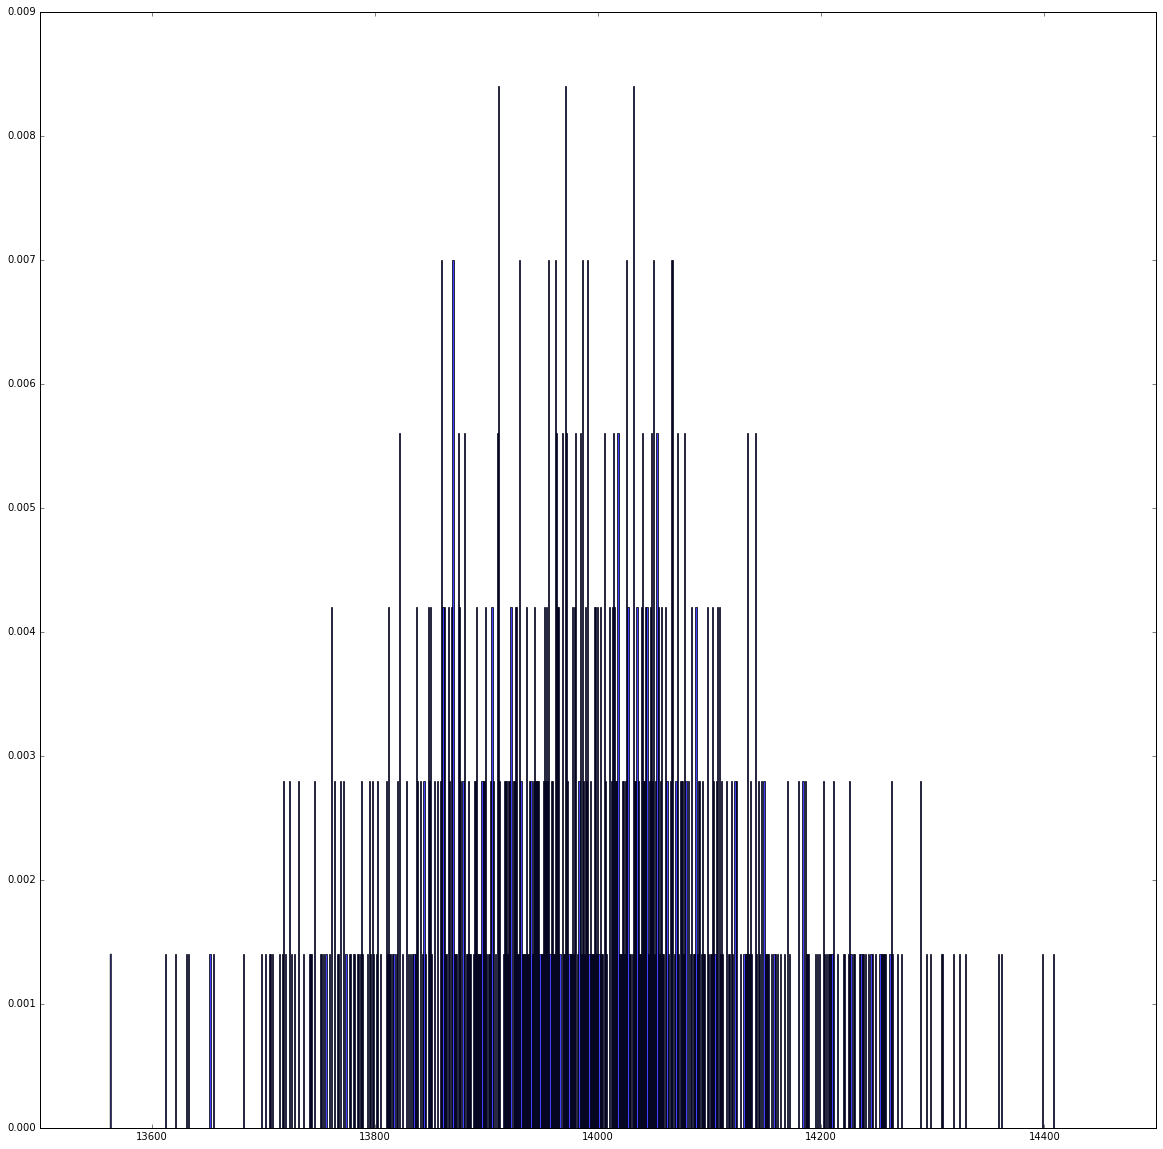

In [55]:
maxct = np.amax(uniqueSamples.values())
minct = np.amin(uniqueSamples.values())
vals = sp.special.binom(n,k)
obsVals = len(uniqueSamples)
eCt = reps/vals
print vals, obsVals, eCt, minct, maxct, maxct-minct
print sp.stats.chisquare(uniqueSamples.values(), axis=None)
ns, bins, patches = plt.hist(uniqueSamples.values(), maxct-minct+1, normed=1, facecolor='blue', alpha=0.75)
plt.rcParams['figure.figsize'] = (20.0, 20.0) 

RANDU hits all 715 possible samples, but far from equally often.

Based on the chi-square test, the $p$-value for the hypothesis that these $10^7$ samples are simple random samples is $< 2\times 10^{-9}$.

### Distributional differences.

How much does the difference between the actual distribution on samples and the SRS distribution matter?

Suppose we have a random variable $X$ defined on samples $\omega \in \Omega \equiv \{ \omega \subset [x_1, \ldots, x_n] \mbox{ s.t. } |\omega| = k \}$, where $[]$ denotes a
multiset (i.e., the values $x_j$ need not be distinct), and
$|\omega|$ is the cardinality of the multiset $\omega$.

We'd like to know how much the expected value of $X$ can differ when $\omega$ is drawn from two different distributions, one, $F$, in which $\omega$ is uniform on $\Omega$ (simple random sampling), and the distribution induced by using a particular PRNG and sampling algorithm to simulate random samples, e.g., `PIKK` with `RANDU`.

$$ | {\mathbb E}_F X - {\mathbb E}_G X | \le \|F-G\|_1 \sup_{\omega \in \Omega} |X(\omega)|.$$

Note that $\Omega$ consists of unordered samples, not sequences of observations:
we are not considering, for instance, letting $X$ be the test function of a sequential test.)

If we know that the support of $G$ omits $n_0$ possible samples of $n \choose k$, then the $L_1$ distance between $F$ and $G$ must be at least $\frac{2 n_0}{{n \choose k}}$, and hence, for if $X$ chosen to maximize the difference, the difference in expectation is at least $\frac{2n_0\sup_{\omega \in \Omega}|X(\omega)|}{{n \choose k}}$, and possibly larger.

**Start with some numerical experiments for particular random variables $X$, including the sample mean.**

In [24]:
# Look at counts of item hits across samples
itemCounts = dict()
for u,v in uniqueSamples.items():
    for i in u:
        if i in itemCounts:
            itemCounts[i] += v
        else:
            itemCounts[i] = v

print itemCounts.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [25]:
for i in itemCounts.keys():
    itemCounts[i] /= reps
    print i, itemCounts[i]

minp, meanp, maxp =  np.amin(itemCounts.values()), np.mean(itemCounts.values()), np.max(itemCounts.values())
print minp, meanp, maxp

0 0.3076871
1 0.3077878
2 0.3080641
3 0.3075428
4 0.3076046
5 0.3074774
6 0.3077228
7 0.307794
8 0.3078113
9 0.3074833
10 0.3078241
11 0.3075414
12 0.3076593
0.3074774 0.307692307692 0.3080641


In [29]:
x = [0]*n
x[2] = 1  # item most likely to be selected
# x[9] = -1 # item least likely to be selected
popMean = np.mean(x)
print popMean

0.0769230769231


In [31]:
m = 0
totCnt = 0
for sam, cnt in uniqueSamples.items():
    m += np.mean([x[i] for i in sam])*cnt
    totCnt += cnt

samMean = m/totCnt
print samMean, (popMean-samMean)/popMean, totCnt, 2**32

0.077016025 -0.001208325 10000000 4294967296


In this example, the sample mean is biased downwards by about 0.12%. This is not averaged over a full cycle of the PRNG, though.

### Results for other PRNGs

In [ ]:
# Marsaglia's SUPER-DUPER LCG 

A_SD = 0
B_SD = 69069
M_SD = 2**32

reps = int(10**7)

n = 13
k = 4

lcg = lcgRandom(seed=100, A=A_SD, B=B_SD, M=M_SD) # set seed of Super-duper to 100
uniqueSamples = dict()

for i in xrange(reps):
    sam = frozenset(PIKK(n, k, lcg))
    if sam in uniqueSamples:
        uniqueSamples[sam] += 1
    else:
        uniqueSamples[sam] = 1

In [ ]:
maxct = np.amax(uniqueSamples.values())
minct = np.amin(uniqueSamples.values())
vals = sp.special.binom(n,k)
obsVals = len(uniqueSamples)
eCt = reps/vals
print vals, obsVals, eCt, minct, maxct, maxct-minct
print sp.stats.chisquare(uniqueSamples.values(), axis=None)
ns, bins, patches = plt.hist(uniqueSamples.values(), maxct-minct+1, normed=1, facecolor='blue', alpha=0.75)
plt.rcParams['figure.figsize'] = (20.0, 20.0) 

Super-duper hits all 715 cells, more nearly equally often than RANDU does.

In [ ]:
# Compare with MT
reps = int(10**7)

n = 13
k = 4

np.random.seed(seed=100) # set seed to 100
uniqueSamples = dict()

for i in xrange(reps):
    sam = frozenset(PIKK(n, k, np.random))
    if sam in uniqueSamples:
        uniqueSamples[sam] += 1
    else:
        uniqueSamples[sam] = 1

In [ ]:
maxct = np.amax(uniqueSamples.values())
minct = np.amin(uniqueSamples.values())
vals = sp.special.binom(n,k)
obsVals = len(uniqueSamples)
eCt = reps/vals
print vals, obsVals, eCt, maxct,  minct
print sp.stats.chisquare(uniqueSamples.values(), axis=None)
ns, bins, patches = plt.hist(uniqueSamples.values(), maxct-minct+1, normed=1, facecolor='blue', alpha=0.75)
plt.rcParams['figure.figsize'] = (20.0, 20.0) 

`MT` hits all 715 possible samples much more evenly than `RANDU` but less than `SUPER-DUPER`: the $p$-value is about 0.64.

### Test with larger values

In [14]:
# RANDU
reps = int(10**7)

n = 40
k = 5

lcg = lcgRandom(seed=100) # set seed of RANDU to 100
uniqueSamples = dict()

for i in xrange(reps):
    sam = frozenset(PIKK(n, k, lcg))
    if sam in uniqueSamples:
        uniqueSamples[sam] += 1
    else:
        uniqueSamples[sam] = 1

658008.0 658006 15.1973836184 1 49 48
Power_divergenceResult(statistic=655445.95483520022, pvalue=0.98722730913449219)


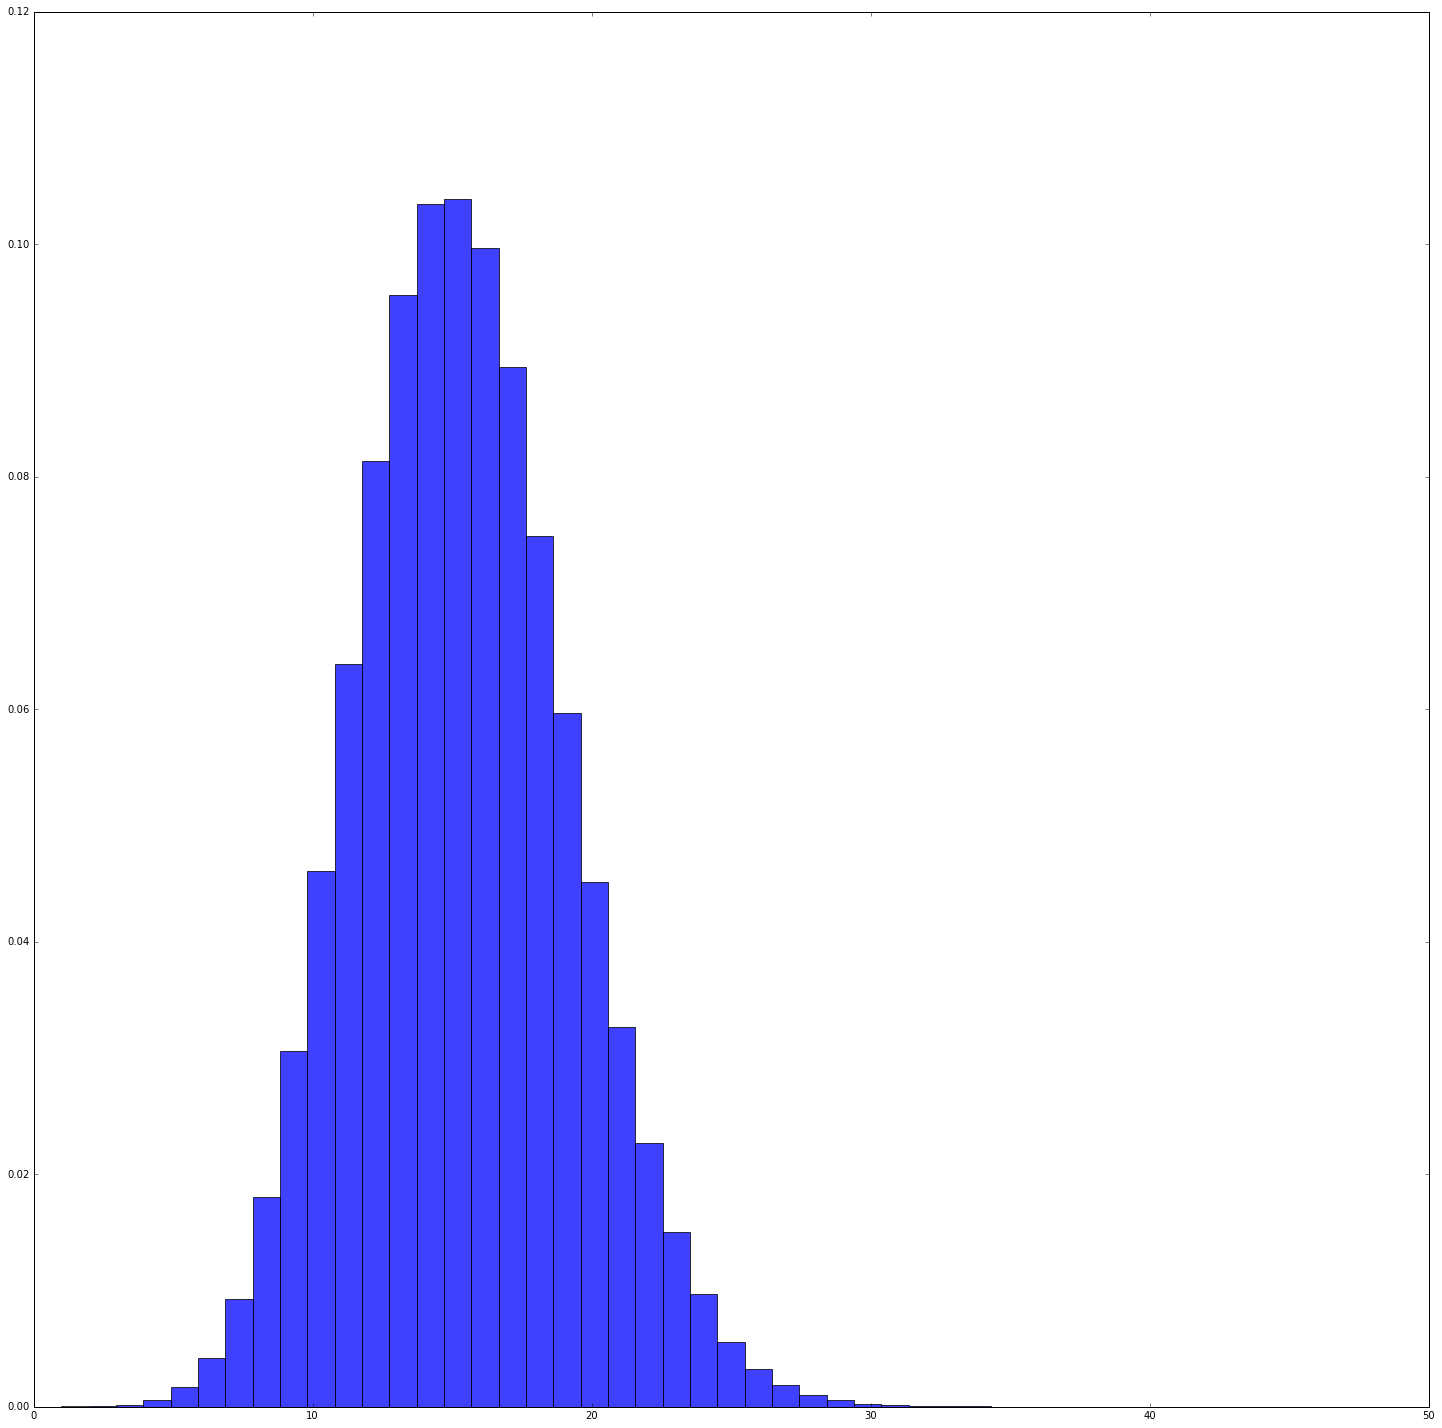

In [15]:
maxct = np.amax(uniqueSamples.values())
minct = np.amin(uniqueSamples.values())
vals = sp.special.binom(n,k)
obsVals = len(uniqueSamples)
eCt = reps/vals
print vals, obsVals, eCt, minct, maxct, maxct-minct
print sp.stats.chisquare(uniqueSamples.values(), axis=None) ## not an adequate test
ns, bins, patches = plt.hist(uniqueSamples.values(), maxct-minct+1, normed=1, facecolor='blue', alpha=0.75)
plt.rcParams['figure.figsize'] = (20.0, 20.0) 

RANDU hits 658006 of the 658008 possible samples, far from equally often (never to 49 times, versus the expected 15.2 times).

### Distributional differences

Can lower bound the $l_1$ distance between this distribution on $k$-samples and the SRS distribution.

First look at the empirical frequency of individual items in the population.

In [25]:
itemCounts = dict()
for u,v in uniqueSamples.items():
    for i in u:
        if i in itemCounts:
            itemCounts[i] += v
        else:
            itemCounts[i] = v

print itemCounts.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [26]:
for i in itemCounts.keys():
    itemCounts[i] /= reps
    print i, itemCounts[i]
print np.amax(itemCounts.values()), np.amin(itemCounts.values())

0 0.1250617
1 0.1250208
2 0.1249963
3 0.1249572
4 0.1249275
5 0.1247718
6 0.1248838
7 0.1249491
8 0.1249039
9 0.1249589
10 0.1251025
11 0.125035
12 0.1249921
13 0.12508
14 0.1250235
15 0.1250144
16 0.1249559
17 0.1249403
18 0.1249856
19 0.1251117
20 0.1249548
21 0.1251378
22 0.1249963
23 0.1250586
24 0.1249587
25 0.1249813
26 0.125105
27 0.1249774
28 0.1250476
29 0.1252186
30 0.1250247
31 0.1250135
32 0.1249409
33 0.1249492
34 0.1250081
35 0.1250039
36 0.1250027
37 0.1249608
38 0.1250121
39 0.124976
0.1252186 0.1247718


In [49]:
print 0.1252186/0.1247718
print [i for i in itemCounts.keys() if itemCounts[i] > 0.1252 ]

1.00358093736
[29]


In [50]:
x = [0]*n
# x[10] = x[19] = x[21] = x[26] = x[29] = 1 for 0.1251
x[29] = 1
popMean = np.mean(x)
print popMean

0.025


In [51]:
m = 0
totCnt = 0
for sam, cnt in uniqueSamples.items():
    m += np.mean([x[i] for i in sam])*cnt
    totCnt += cnt

samMean = m/totCnt
print samMean, totCnt

0.02504372 10000000


In [53]:
## standard error of the mean is sqrt(0.125*0.875)/sqrt(40)
se = math.sqrt(0.125*0.875)/math.sqrt(5)
print se, samMean-popMean, (samMean - popMean)/se, (samMean-popMean)

0.147901994577 4.37199999999e-05 0.000295601152133 0.0017488


In [ ]:
# Marsaglia's SUPER-DUPER LCG 

A_SD = 0
B_SD = 69069
M_SD = 2**32

reps = int(10**7)

n = 40
k = 5

lcg = lcgRandom(seed=100, A=A_SD, B=B_SD, M=M_SD) # set seed of Super-duper to 100
uniqueSamples = dict()

for i in xrange(reps):
    sam = frozenset(PIKK(n, k, lcg))
    if sam in uniqueSamples:
        uniqueSamples[sam] += 1
    else:
        uniqueSamples[sam] = 1

In [ ]:
maxct = np.amax(uniqueSamples.values())
minct = np.amin(uniqueSamples.values())
vals = sp.special.binom(n,k)
obsVals = len(uniqueSamples)
eCt = reps/vals
print vals, obsVals, eCt, minct, maxct, maxct-minct
print sp.stats.chisquare(uniqueSamples.values(), axis=None)
ns, bins, patches = plt.hist(uniqueSamples.values(), maxct-minct+1, normed=1, facecolor='blue', alpha=0.75)
plt.rcParams['figure.figsize'] = (20.0, 20.0) 

Super-duper hits ???

In [ ]:
# Compare with MT
reps = int(10**7)

n = 40
k = 5

np.random.seed(seed=100) # set seed to 100
uniqueSamples = dict()

for i in xrange(reps):
    sam = frozenset(PIKK(n, k, np.random))
    if sam in uniqueSamples:
        uniqueSamples[sam] += 1
    else:
        uniqueSamples[sam] = 1

In [ ]:
maxct = np.amax(uniqueSamples.values())
minct = np.amin(uniqueSamples.values())
vals = sp.special.binom(n,k)
obsVals = len(uniqueSamples)
eCt = reps/vals
print vals, obsVals, eCt, maxct,  minct
print sp.stats.chisquare(uniqueSamples.values(), axis=None)
ns, bins, patches = plt.hist(uniqueSamples.values(), maxct-minct+1, normed=1, facecolor='blue', alpha=0.75)
plt.rcParams['figure.figsize'] = (20.0, 20.0) 

<hr />
# Coding samples 

Above, considered particular algorithms that use PRNGs to select $k$ of $n$ elements

There are ${n \choose k}$ possible
samples of size $k$ from a population of size $n$.
Imagine simply numbering them: taking a sample would require specifying only which of the samples to draw.

This amounts to sending a 1-letter message in an ${n \choose k}$-letter alphabet,
where every 1-letter message has the same probability in the language.

Shannon's coding theory implies that the most efficient way to encode such a message requires $\log_2{n \choose k}$ bits.

A PRNG generates a message from its output bits.
The period of the PRNG tells us the maximum number of messages the PRNG can generate starting from a particular seed.
The period times the PRNG word length is the number of random bits that the PRNG can generate.
(Not all the bits are "equally random." For most PRNGs, the high-order bits behave more randomly than the low-order bits.)
If this number is less than the number of bits per sample encoding times the number of samples, ${n \choose k}\log_2{n \choose k}$, then it is not possible to generate all possible samples in one period of the PRNG, i.e., to list all the letters in the alphabet.

For any particular PRNG period and word length (typically 32 bits), we can fix $k$ and calculate the largest $n$ for which the PRNG could possibly enumerate all possible samples.
Similarly, we can fix $n$ and find the largest $k$ for which the PRNG can generate all possible samples.
Only interesting for $1 \leq k \leq \lfloor{\frac{n}{2}}\rfloor$.
(For $k > \lfloor{\frac{n}{2}}\rfloor$, think of sampling as selecting individuals to *exclude*.)

For large $n$, hard to compute binomial coefficients.
Instead, we use the following bound:

$$ \frac{2^{nH(k/n)}}{n+1} \leq {n \choose k} \leq 2^{nH(k/n)}$$

For the Mersenne Twister, use the lower bound for ${n \choose k}$, giving overly optimistic estimates of maximum $n$.

In [ ]:
# number of bits per period divided by log_2(choose(n,k))?
def sample_counter(n, k, period, word_length):
    c = comb(n,k)
    return (period*word_length) > math.log(c, 2)*c


def sample_counter_lb(n, k, period, word_length):
    ub_bits_for_all_samples = (n*H(k/n) - math.log(n+1, 2))*(2**(n*H(k/n)))/(n+1)
    return (period*word_length) > ub_bits_for_all_samples

## Mersenne Twister

## Common packages

| Package/Lang   | default    | other      | SRS algorithm  |
|:---------------|:----------:|:----------:|:--------------:|
| SAS 9.2        | MT         | 32-bit LCG |                |
| SPSS 20.0      | 32-bit LCG | MT1997ar   |                |
| SPSS &le; 12.0 | 32-bit LCG |            |                |
| STATA 13       | KISS 32    |            |                |
| STATA 14       | MT         |            |                |
| R              | MT         |            | trunc          |
| python         | MT         |            | mask           |
| MATLAB         | MT         |            |                |

**Key.** MT = Mersenne Twister. LCG = linear congruential generator. ANS = "assign a number to each of the $n$ items and sort." The KISS generator combines 4 generators of three types: two multiply-with-carry
generators, the 3-shift register SHR3 and the congruential generator CONG.

## Best Practices

+ Use a source of real randomness to set the seed with a substantial amount of entropy, e.g., 20 rolls of 10-sided dice.
+ Record the seed so your analysis is reproducible.
+ Use a PRNG at least as good as the Mersenne Twister, and preferably a cryptographic quality PRNG. Consider the PCG family. Avoid linear the usual congruential generators and the Wichmann-Hill generator.
+ Use open-source software, and record the version of the software you use.
+ Use a sampling algorithm that does not "waste randomness." Avoid permuting the entire population.
+ Be aware of discretization issues in the sampling algorithm; many methods assume the PRNG produces $U[0,1]$ or $U[0,1)$ random numbers, rather than (an approximation to) numbers that are uniform on $w$-bit binary integers.
+ Consider the size of the problem: are your PRNG and sampling algorithm adequate?
+ Avoid "tests of representativeness" and procedures that reject some samples. They alter the distribution of the sample.

In [ ]:
print comb(41400,100)
print comb_upper_bound_H(41400, 100)
print comb_lower_bound_H(41400, 100)
# print comb_lower_bound_Stirling(100,414)

In [ ]:
%load_ext version_information
%version_information scipy, numpy, pandas, matplotlib, notebook

In [ ]:
# %load talktools.py
"""Tools to style a talk."""

from IPython.display import HTML, display, YouTubeVideo

def prefix(url):
    prefix = '' if url.startswith('http') else 'http://'
    return prefix + url


def simple_link(url, name=None):
    name = url if name is None else name
    url = prefix(url)
    return '<a href="%s" target="_blank">%s</a>' % (url, name)


def html_link(url, name=None):
    return HTML(simple_link(url, name))


# Utility functions
def website(url, name=None, width=800, height=450):
    html = []
    if name:
        html.extend(['<div class="nb_link">',
                     simple_link(url, name),
                     '</div>'] )

    html.append('<iframe src="%s"  width="%s" height="%s">' %
                (prefix(url), width, height))
    return HTML('\n'.join(html))


def nbviewer(url, name=None, width=800, height=450):
    return website('nbviewer.ipython.org/url/' + url, name, width, height)

# Load and publish CSS
style = HTML(open('talkStyle.css').read())

display(style)